In [9]:
library("DESeq2")
library("biomaRt")
dir_counts <- "/home/rtu/Applied-Bioinformatics/Applied-Bioinformatics-Course/Unit2-RNAseq/data/htseq_out/day5"
counts_files <- list.files(dir_counts)
samplesInfo <- as.data.frame(matrix(ncol=2, nrow=length(counts_files)))  
samplesInfo$samplename <- counts_files  
samplesInfo$filename <- counts_files  
samplesInfo$group <- c("mock", "ZIKV", "mock", "ZIKV", "mock", "ZIKV","mock","ZIKV","mock","ZIKV") 
#Remove the blank columns
samplesInfo <- samplesInfo[,-c(1:2)]
dds1 <- DESeqDataSetFromHTSeqCount(sampleTable = samplesInfo, 
                                           directory = dir_counts, 
                                           design = ~ group)
#### Run the main DESeq normalization and analysis function
dds1_deseq <- DESeq(dds1)
rld <- rlog(dds1_deseq)
vsd <- varianceStabilizingTransformation(dds1_deseq)
res <- results(dds1_deseq, contrast=c("group", "ZIKV", "mock"))
summary(res)
resSorted <- res[order(res$padj),]
# EMSEMBL ids 
bm <- useMart(biomart = "ensembl")
bm <- useDataset(dataset = "hsapiens_gene_ensembl", mart = bm)
ens2genesymbol <- getBM(mart = bm, attributes = c('ensembl_gene_id', 'external_gene_name'))


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing



out of 39405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 442, 1.1%
LFC < 0 (down)     : 632, 1.6%
outliers [1]       : 29, 0.074%
low counts [2]     : 20077, 51%
(mean count < 11)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Installing libraries
```
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("org.Hs.eg.db", version = "3.8")
BiocManager::install("clusterProfiler", version = "3.8")
```

In [3]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("org.Hs.eg.db", version = "3.8")
BiocManager::install("clusterProfiler", version = "3.8")

Bioconductor version 3.8 (BiocManager 1.30.4), R 3.5.1 (2018-07-02)
Installing package(s) 'org.Hs.eg.db'
installation path not writeable, unable to update packages: lattice, MASS,
  Matrix, mgcv, rpart, survival
Update old packages: 'IRdisplay', 'RcppArmadillo', 'VariantAnnotation'
Bioconductor version 3.8 (BiocManager 1.30.4), R 3.5.1 (2018-07-02)
Installing package(s) 'clusterProfiler'
also installing the dependencies ‘farver’, ‘triebeard’, ‘tweenr’, ‘units’, ‘fastmatch’, ‘urltools’, ‘gridGraphics’, ‘ggforce’, ‘DO.db’, ‘fgsea’, ‘cowplot’, ‘europepmc’, ‘ggplotify’, ‘ggraph’, ‘ggridges’, ‘igraph’, ‘UpSetR’, ‘DOSE’, ‘enrichplot’, ‘GOSemSim’, ‘qvalue’, ‘rvcheck’

Warning message in install.packages(pkgs = doing, lib = lib, repos = repos, ...):
“installation of package ‘units’ had non-zero exit status”Warning message in install.packages(pkgs = doing, lib = lib, repos = repos, ...):
“installation of package ‘igraph’ had non-zero exit status”Warning message in install.packages(pkgs = doing,

In [11]:
library(clusterProfiler)
library(org.Hs.eg.db)


clusterProfiler v3.10.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:DelayedArray’:

    simplify

Loading required package: AnnotationDbi



## Volcano Plot
Let's redo the volcano plot we had used before. 

This time however let's highlight the differentially expressed genes with a **fold change >= 2** and **p-value <= 0.01**.

Let's remove NAs from resSorted$padj

In [12]:
resFilteredSorted <- resSorted[complete.cases(resSorted$padj),]
dim(resFilteredSorted)

[1] 19299     6

Let's create a column "selected" an set value to **TRUE** or **FALSE** based on whether they satisfy our conditions.

In [13]:
resFilteredSorted[,"selected"] <- FALSE
resFilteredSorted[resFilteredSorted$padj <= 0.01 & abs(resFilteredSorted$log2FoldChange) >= 1, "selected"] <- TRUE

Let's now plot the volcano plot. log2Foldchange on the xaxis and -log10(padj) on yaxis.

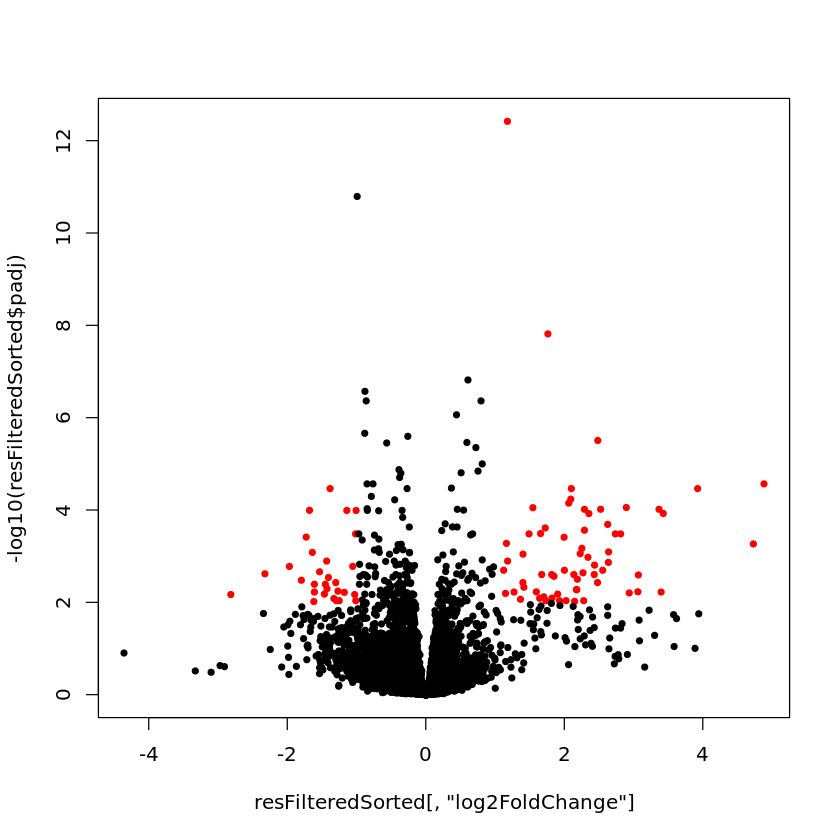

In [14]:
plot(resFilteredSorted[,"log2FoldChange"], -log10(resFilteredSorted$padj), col=as.factor(resFilteredSorted$selected), pch=20)

Let's try and plot the text for each gene. We've already retrieved the symbol for the ENSEMBL id using the *getBM()* function in the bioMart package.

In [15]:
# Select rows from resFilteredSort that match out conditions.
df.selected <- resFilteredSorted[resFilteredSorted$padj <= 0.01 & abs(resFilteredSorted$log2FoldChange) >= 1,]
# Loop over ens2genesymbol dataframe that was created before to get the gene name for each ENSEMBL ID
df.labels <- sapply(rownames(df.selected), function(x){
    ens2genesymbol[ens2genesymbol["ensembl_gene_id"]==x,"external_gene_name"]
})

Now let's plot!

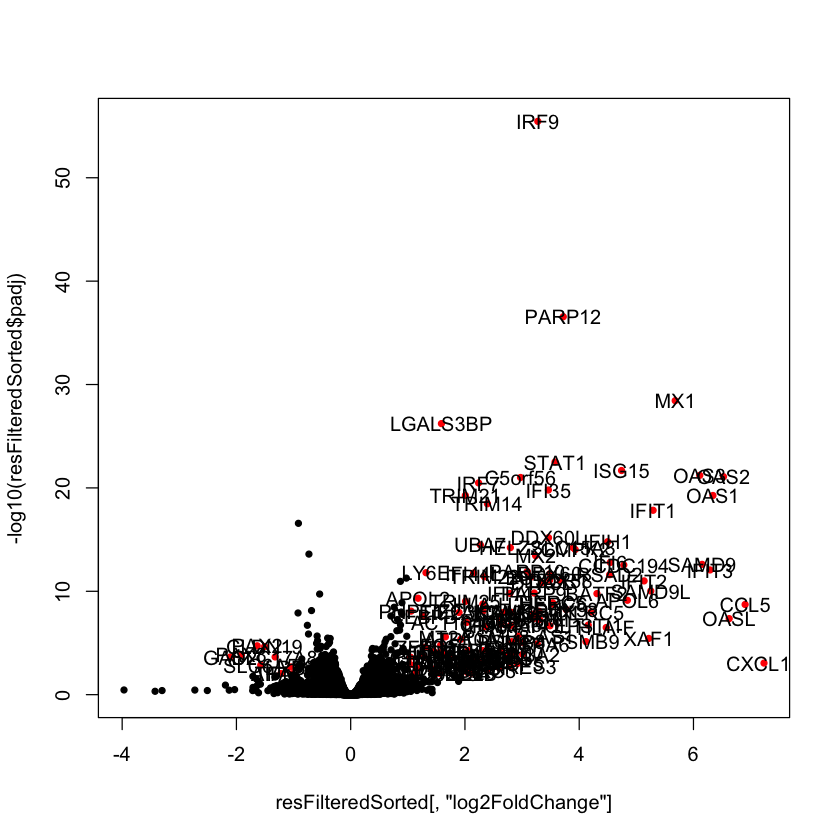

In [7]:
plot(resFilteredSorted[,"log2FoldChange"], -log10(resFilteredSorted$padj), col=as.factor(resFilteredSorted$selected), pch=20)
text(df.selected[,"log2FoldChange"], -log10(df.selected$padj), labels = df.labels)

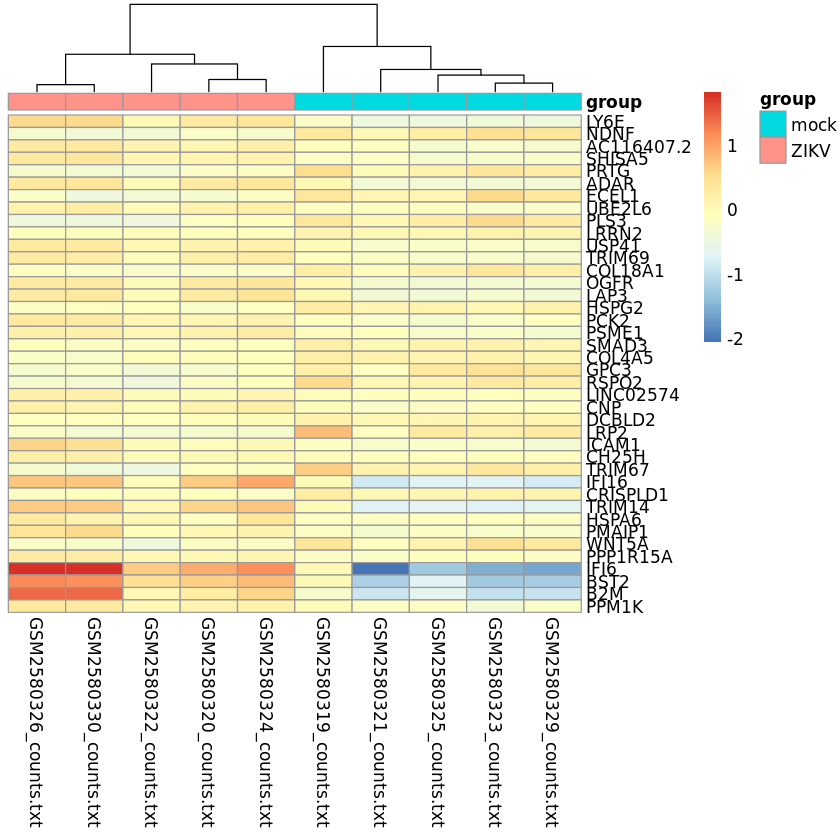

In [16]:
library(pheatmap)
df <- data.frame(colData(rld)[,"group"])
rownames(df) <- rownames(colData(rld))
colnames(df) <- c("group")

ngenes <- 40
deg <- rownames(resSorted)[1:ngenes]
mat <- assay(rld)[deg,]
mat <- mat - rowMeans(mat)
rownames(mat) <- sapply(rownames(resSorted)[1:ngenes], function(x){
    return(ens2genesymbol[ens2genesymbol[,"ensembl_gene_id"]==x,"external_gene_name"]);
})

pheatmap(mat,
        annotation_col = df,
        cluster_cols = T,
        cluster_rows=F)

## Go enrichment

Let's now map the ENSEMBL ids to GO ids using the *bitr()* function.

In [17]:
gomap <- bitr(rownames(resFilteredSorted), "ENSEMBL", "GO", org.Hs.eg.db, drop = TRUE)

'select()' returned 1:many mapping between keys and columns
Warning message in bitr(rownames(resFilteredSorted), "ENSEMBL", "GO", org.Hs.eg.db, :
“26.43% of input gene IDs are fail to map...”

Let's now select the unique EMSEMBL and GO id pairs from the Molecular Function(MF) domain.

In [18]:
gomap.f <- gomap[gomap$ONTOLOGY=="MF",]
gomap.f <- unique(gomap.f[,c("ENSEMBL", "GO")])

In [19]:
head(gomap.f)

,ENSEMBL,GO
6,ENSG00000160932,GO:0030550
12,ENSG00000173376,GO:0005539
16,ENSG00000173376,GO:0008201
27,ENSG00000164054,GO:0005515
40,ENSG00000166450,GO:0038023
43,ENSG00000160710,GO:0003677


Let's now get the human readable descriptions of the GO ids.

In [20]:
gomap.descriptions <- go2term(unique(gomap.f$GO))
head(gomap.descriptions)

go_id,Term
GO:0044183,protein binding involved in protein folding
GO:0051082,unfolded protein binding
GO:0003756,protein disulfide isomerase activity
GO:0015036,disulfide oxidoreductase activity
GO:0000010,trans-hexaprenyltranstransferase activity
GO:0000014,single-stranded DNA endodeoxyribonuclease activity


Let's now create a new column, "GO_TERM" in the gomap.f dataframe and add the description there.

In [13]:
gomap.f$GO_TERM <- sapply(gomap.f$GO, function(x){
    return(gomap.descriptions[gomap.descriptions$go_id==x,"Term"]);
})

In [14]:
head(gomap.f)

,ENSEMBL,GO,GO_TERM
1,ENSG00000213928,GO:0000978,RNA polymerase II proximal promoter sequence-specific DNA binding
2,ENSG00000213928,GO:0000981,"DNA-binding transcription factor activity, RNA polymerase II-specific"
5,ENSG00000213928,GO:0003700,DNA-binding transcription factor activity
6,ENSG00000213928,GO:0005515,protein binding
18,ENSG00000059378,GO:0003723,RNA binding
19,ENSG00000059378,GO:0003950,NAD+ ADP-ribosyltransferase activity


Let's get a table of the counts of each GO term

In [15]:
gomap.f.table <- table(gomap.f$GO_TERM)
# Sort table by count
gomap.f.table <- gomap.f.table[order(gomap.f.table, decreasing=TRUE)]

Let's make a piechart of the top 20 GO terms using the table!

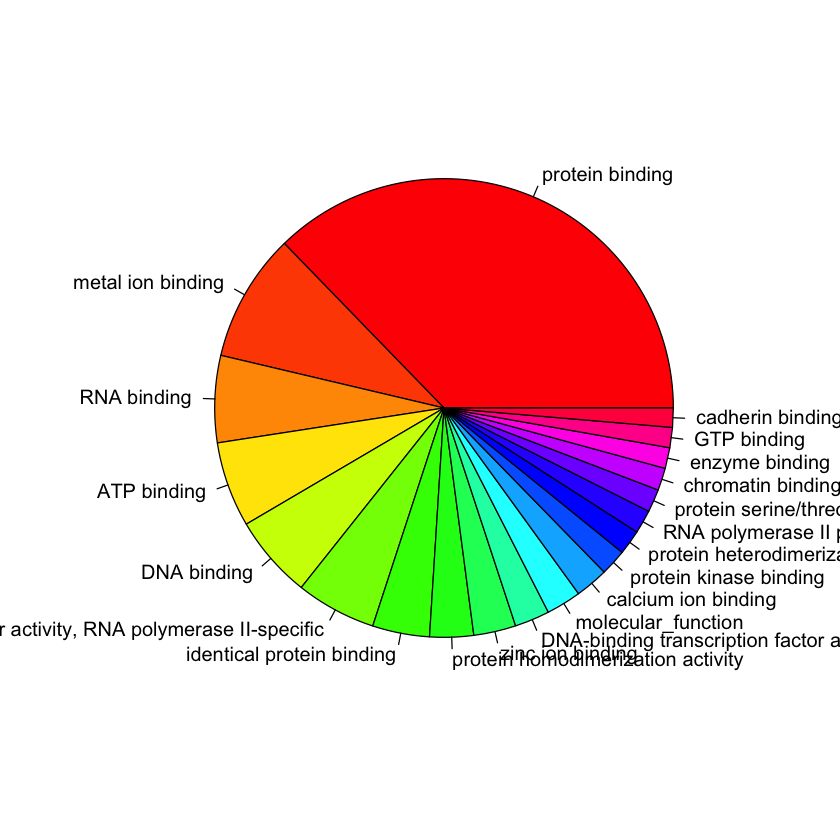

In [16]:
# raindow is just a colorscheme.
pie(gomap.f.table[1:20], col = rainbow(20))